In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import copy

from simulate import SimulateData
import numba_functions
from hmm import HMM
from sklearn.metrics.cluster import adjusted_rand_score as ari

In [2]:
import pickle

# Load state sequence and data from the pickle file
with open('hmm_data.pkl', 'rb') as file:
    loaded_data = pickle.load(file)

# Access the loaded data
loaded_ss = loaded_data['state_sequence']
loaded_data = loaded_data['data']
import plot_hmm

In [16]:
from importlib import reload
import numba_functions
reload(numba_functions)
import mv_bayesian_hmm
reload(mv_bayesian_hmm)


<module 'mv_bayesian_hmm' from '/Users/david/Documents/mastersCode/ubm/tuts/bhmm/mv_bayesian_hmm.py'>

init ari 0.496


/Users/david/Documents/mastersCode/ubm/tuts/bhmm/plot_hmm.py:10: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ellipse = Ellipse(mu, w, h, theta, color=color, edgecolor='black')  # edgecolor for better visibility


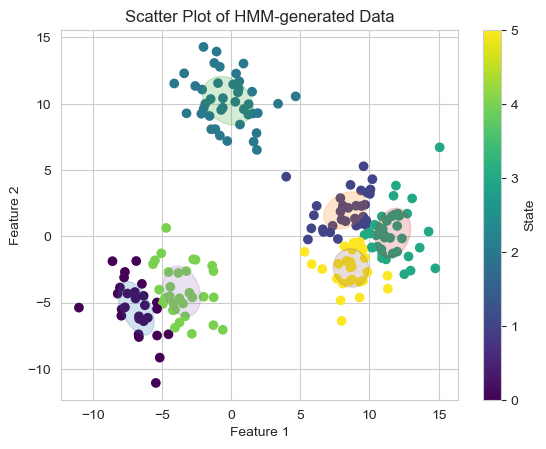

In [19]:
new_hmm = mv_bayesian_hmm.BayesianHMM(loaded_data, loaded_ss, 6, iterations=50)

In [20]:
new_hmm.fit()

starting gibbs sampling
deleting comp 5
deleting comp 1
deleting comp 3
completed gibbs sampling


In [6]:

# init things
from sklearn.cluster import KMeans
from scipy.stats import  wishart, dirichlet, invwishart, multivariate_normal
from sklearn.metrics.cluster import adjusted_rand_score as ari
from sklearn.mixture._gaussian_mixture import _compute_precision_cholesky

class BayesianHMM():

    def __init__(self, X, Z_true, K, burn_in=0, iterations=20):
        """
        [] input
        X = data n x d
        K = expected amount of states

        [] params = pi, A, z, mu, Sigma
        init z and pi using uniform alpha, mu and sigma using data and z assignments

        [] hyper-params = rho, alpha, m0, V0, nu0, S0
        for uniform priors we set
        rh0, alpha0 -> small value to allow for states to collapse for pi and A
        m0 -> mean of init assignments
        V0 -> large eye matrix
        nu0 -> K + 1
        S0 -> data scatter matrix

        [] ss
        nk - count of data in each k
        x_bar - mean of data in each k
        """
        self.X = X  # data n x d
        self.K = K  # expected no of states
        self.burn_in = burn_in
        self.iterations = iterations
        self.N = X.shape[0] # length of data
        self.D = X.shape[1] # dimension of data
        self.Z_true = Z_true



        # init z matrix randomly along with pie and A
        self.alpha0 = np.ones(K) * 1000/self.K # Uniform prior
        self.pi = dirichlet.rvs(alpha=self.alpha0, size=1).flatten()
        self.A = dirichlet.rvs(alpha=self.alpha0, size=K)
        Z_mat = np.random.multinomial(n=1, pvals=self.pi, size=self.N)
        _, self.Z = np.where(Z_mat == 1) # N x 1 component number

        self.alpha0 = np.ones(K) * 10 / self.K  # small prior
        self.rho0 = np.array([np.ones(K) * 10 / self.K for i in range(K)]) # small prior
        # update alpha0 here for weights to collapse

        # true means
        kmeans = KMeans(n_clusters=K, random_state=42)
        kmeans.fit(X)

        self.true_means_ = kmeans.cluster_centers_
        self.true_covars_ = [np.cov(X[kmeans.labels_ == i], rowvar=False) for i in range(K)]

        # shuffle labels
        num_labels_to_replace = int(0.05 * len(kmeans.labels_))
        # Generate random labels between 0 and k
        random_labels = np.random.randint(0, K, num_labels_to_replace)
        # Replace 10% of the labels with random numbers
        shuffled_labels = np.copy(kmeans.labels_)
        replace_indices = np.random.choice(len(shuffled_labels), num_labels_to_replace, replace=False)
        shuffled_labels[replace_indices] = random_labels
        # Assign the shuffled labels to self.Z
        self.Z = kmeans.labels_
        print('init ari', np.round(ari(self.Z_true, self.Z), 3))


        # sufficient stats
        self.nk = np.zeros(self.K, dtype=int)
        self.x_bar = np.zeros((self.K, self.D), dtype=float)
        for k in range(K):
            self.nk[k] = np.sum(self.Z == k)
            self.x_bar[k] = np.mean(self.X[self.Z == k], axis=0)

        # init mu and Sigma
        self.mu = np.zeros((self.K, self.D))
        self.sigma = np.zeros((self.K, self.D, self.D))
        self.lambdas = np.zeros((self.K, self.D, self.D))
        diagsig = np.zeros((self.K, self.D, self.D)) # scatter matrix
        for k in range(K):
            x_k = self.X[self.Z == k]
            if len(x_k) == 0:
                random_indices = np.random.randint(0, self.N, self.N*0.1)
                x_k = self.X[random_indices]
                print(x_k)
            sig_bar = np.cov(x_k.T, bias=True)
            diagsig[k] = np.diag(np.diag(sig_bar))
            self.mu[k] = self.x_bar[k]
            self.sigma[k] = sig_bar
            self.lambdas[k] = np.linalg.inv(sig_bar)
        # Hyper-parameters for normals
        # Mu
        self.m0 = np.copy(self.x_bar) # K x D
        if np.isnan(self.m0).any():
            print('nan')
        self.V0 = [np.eye(self.D) * 1000 for _ in range(K)] # K x D x D
        # Sigma
        self.S0 = diagsig # K x D x D
        self.nu0 = np.copy(self.K) + 1  # 1 Degrees of freedom IW

        self.mu_trace = []
        self.sigma_trace = []
        self.pi_trace = []
        self.ARI = np.zeros((self.iterations))
        self.likelihood_history = []

        plot_hmm.plot_hmm_data(loaded_data, self.Z, K, self.mu, self.sigma)

        # hmm
        # self.gammas = None
        # self.xi = None
        # self.alphas = None
        # self.betas = None

    def sample_states(self):

        beta = numba_functions.backward_robust_mv(self.A, self.mu, self.sigma, self.X)

        new_state_path = numba_functions.sample_states_numba_mv(beta,
                                     self.pi,
                                     self.X,
                                     self.mu,
                                     self.sigma,
                                     self.A,
                                     self.N)
        return new_state_path

    # for A
    def get_rho_k(self):
        rho_k = np.zeros((self.K, self.K))
        for i in range(self.K):
            # find indices of states that come right after state i
            indices = np.where(self.Z == i)[0] + 1  # indices of X_k

            # need to address the case for the last state in the sequence
            if self.N in indices:
                indices = np.delete(indices, np.where(indices == self.N))

            states = self.Z[indices]
            n_i = np.zeros(self.K)
            for j in range(self.K):
                n_i[j] = np.count_nonzero(states == j)
            rho_k[i,:] = n_i
        return rho_k

    def fit(self):
        max_iterations = 20
        convergence_threshold = 1e-5
        self.likelihood_history = []

        self.ARI = np.zeros((self.iterations))
        print('starting gibbs sampling')
        for it in range(self.iterations):
            self.gibbs_sweep(it)

            # save trace
            # if it > self.burn_in:
            self.mu_trace.append(self.mu)
            self.sigma_trace.append(self.sigma)
            self.pi_trace.append(self.pi)

            # Calculate ARI
            if self.Z_true is not None:
                self.ARI[it] = np.round(ari(self.Z_true, self.Z), 3)
                # print(f"ARI:{self.ARI[it]}")

            # check likelihood and break if needed
            # current_likelihood = self.calculate_likelihood()
            # self.likelihood_history.append(current_likelihood)
            # if it > 0:
            #     if self.has_converged(likelihood_history[-1], current_likelihood, convergence_threshold):
                    # print(f"Converged after {it} iterations.")
                    # break

        # skl_gmm = mixture.GaussianMixture(n_components=self.K, covariance_type="full")
        # skl_gmm.means_, skl_gmm.covariances_, skl_gmm.weights_, skl_gmm.precisions_cholesky_ = self.mu, self.sigma, self.pi, _compute_precision_cholesky(self.sigma, "full")
        # skl_gmm.precisions_ = skl_gmm.covariances_** 2
        # skl_gmm.converged_ = True
        print('completed gibbs sampling')
        # return skl_gmm

    # one sweep of git sampler, return variables sampled
    def gibbs_sweep(self, it):
        # [1] sample params using assignments
        for k in range(self.K):
            # mu
            Vk = (np.linalg.inv(np.linalg.inv(self.V0[k]) + self.nk[k] * np.linalg.inv(self.sigma[k])))
            term1 = np.dot(np.linalg.inv(self.sigma[k]), self.nk[k] * self.x_bar[k])
            term2 = np.dot(np.linalg.inv(self.V0[k]), self.m0[k])
            mk = (np.dot(Vk, term1 + term2))
            # sample mu
            mu_k = np.random.multivariate_normal(mean=mk, cov=Vk, size=1).flatten()

            self.mu[k] = mu_k

            # sigma
            dif = (self.X[self.Z == k] - self.mu[k])
            Sk = (self.S0[k] + (np.dot(dif.T, dif)))
            nuk = self.nu0 + self.nk[k]
            # sample sigma
            self.sigma[k] = invwishart.rvs(size=1, df=nuk, scale=Sk)

        # sample pi
        alpha_k = self.nk + self.alpha0
        self.pi = dirichlet.rvs(size=1, alpha=alpha_k).flatten()

        # sample A
        rho_k = self.rho0 + self.get_rho_k()
        self.A = [dirichlet.rvs(alpha=rho_k[k], size=1).flatten() for k in range(self.K)]
        self.A = np.vstack(self.A)

        # [2] sample assignments using params
        self.Z = self.sample_states()

        # [3] update ss
        self.handle_empty_components()
        # update ss
        for k in range(self.K):
            self.nk[k] = np.sum(self.Z == k)
            if self.nk[k] == 0:
                self.nk[k] = 1
            self.x_bar[k] = np.mean(self.X[self.Z == k], axis=0)
        if np.any(self.nk == 0):
            print('zero count')
        return self.pi, self.mu, self.sigma

    def delete_component(self, component_to_delete):
        # Remove the component_to_delete
        print('deleting comp', component_to_delete)
        self.A = np.delete(self.A, component_to_delete, axis=0)
        self.A = np.delete(self.A, component_to_delete, axis=1)
        self.A = self.A / np.sum(self.A, axis=1, keepdims=True)  # Normalization along axis=1

        self.rho0 = np.delete(self.rho0, component_to_delete, axis=0)
        self.rho0 = np.delete(self.rho0, component_to_delete, axis=1)
        self.rho0 = self.rho0 / np.sum(self.rho0, axis=1)

        self.pi = np.delete(self.pi, component_to_delete)
        self.alpha0 = np.delete(self.alpha0, component_to_delete)

        self.mu = np.delete(self.mu, component_to_delete, axis=0)
        self.sigma = np.delete(self.sigma, component_to_delete, axis=0)
        self.nk = np.delete(self.nk, component_to_delete)
        self.x_bar = np.delete(self.x_bar, component_to_delete, axis=0)

        # update assignments
        for i in range(self.K):
            if i > component_to_delete:
                self.Z[self.Z == i] -= 1

        self.K -= 1  # Decrement the number of components

    def handle_empty_components(self):
        for k in range(self.K):
            self.nk[k] = np.sum(self.Z == k)
        zero_indices = np.where(self.nk == 0)[0]
        if len(zero_indices) > 0:
            for i in range(1,len(zero_indices)):
                print('more than one zero count Reassigning randomly')
                random_idx = np.random.randint(0, self.N)
                self.Z[random_idx] = zero_indices[i]
                self.nk[i] = 1  # Increment the count
            self.delete_component(zero_indices[0])

my_hmm = BayesianHMM(loaded_data, loaded_ss, 15, iterations=50)
# some_var = my_hmm.init_priors()

init ari 0.243


LinAlgError: Singular matrix

In [ ]:
my_hmm.fit()

In [58]:
-1 == False

False

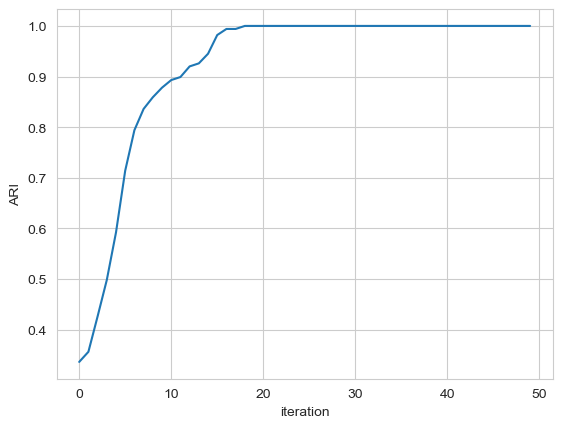

In [32]:
plt.plot(range(0,len(my_hmm.ARI)), my_hmm.ARI, marker="None")
plt.xlabel('iteration')
plt.ylabel('ARI')
#plt.savefig("./image/ari.png")
plt.show()
plt.close()

In [49]:
[multivariate_normal.logpdf(loaded_data[0], mean=mean, cov=cov) for mean, cov in zip(my_hmm.mu, my_hmm.sigma)]

[-6.961083347285227, -6.850037637113035, -6.83278651374772]

/Users/david/Documents/mastersCode/ubm/tuts/bhmm/plot_hmm.py:10: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ellipse = Ellipse(mu, w, h, theta, color=color, edgecolor='black')  # edgecolor for better visibility


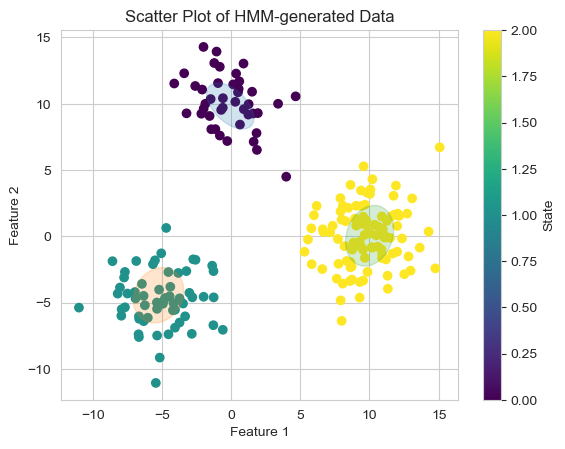

In [33]:
import plot_hmm
plot_hmm.plot_hmm_data(loaded_data, my_hmm.Z, my_hmm.K, my_hmm.mu, my_hmm.sigma)